In [2]:
from models import scribbler 
%load_ext autoreload
%autoreload 2

In [21]:
from models import discriminator

In [22]:
net_G = discriminator.Discriminator(4,32)

In [23]:
net_G(test_var).data.size()

torch.Size([1, 1, 6, 6])

In [134]:
class wrap_tensor(object):
    def __new__(self, tensor, use_gpu=0):
        
        if use_gpu:
            tensor = tensor.gpu()
        
        return Variable(tensor)


In [135]:
a=wrap_tensor(torch.Tensor(1,3,128,128))

In [12]:
class toLAB(object):
    
    def __init__(self):
        self.space = 'LAB'
        
    def __call__(self, image ):
        lab_img = color.rgb2lab(np.array(img)/255.0)
        return lab_img
    
class toRGB(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, img):
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        rgb_img = color.lab2rgb(np.array(npimg))
        return rgb_img
    
class toTensor(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, pic):
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        return img
        

In [27]:
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

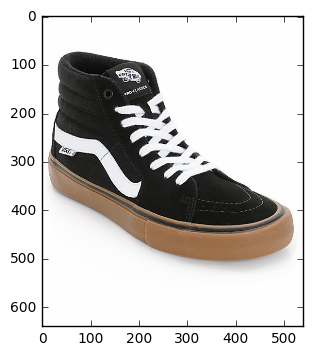

In [28]:
img=Image.open('test.jpg')

lab_img = color.rgb2lab(np.array(img)/255.0)
rgb_img = color.lab2rgb(lab_img)

plt.imshow(rgb_img)

In [29]:
tensorify=toTensor()

In [30]:
img = tensorify(lab_img)
npimg = np.transpose(img.numpy(), (1, 2, 0))


ImportError: cannot import name transforms

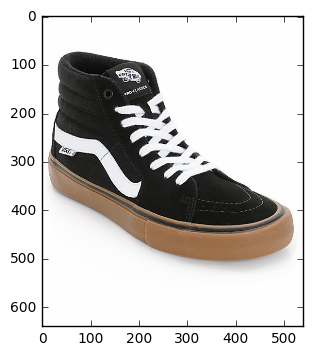

In [31]:
img=Image.open('test.jpg')

process=transforms.ToTensor()
labify=toLAB()
lab_img=labify(img)
lab_tensor=tensorify(lab_img)
rgbify=toRGB()
rgb_img=rgbify(lab_tensor)

plt.imshow(rgb_img)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

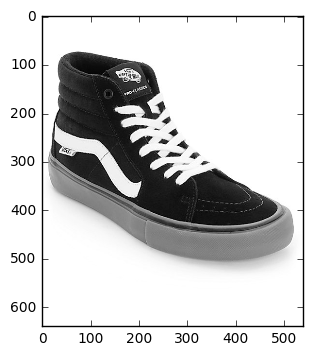

In [32]:
plt.imshow(lab_img[:,:,0]*255,cmap='gray')

In [33]:
import torch
import torchvision.transforms as transforms

In [34]:
from IPython.display import display

In [35]:
show_lab=transforms.Compose([toRGB(),transforms.ToPILImage()])

In [36]:
import torchvision.models as models

In [37]:
feat_model=models.vgg19(pretrained=True)

In [38]:
feat_model=feat_model.double()

In [84]:
from torch.autograd import Variable
lab_var = Variable(lab_tensor.unsqueeze(0),requires_grad=True)
A,B,C=torch.chunk(lab_var,3,dim=1)

In [85]:
AAA=torch.cat((A,A,A),1)

In [75]:
AAA

Variable containing:
( 0 , 0 ,.,.) = 
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
              ...                ⋱                ...             
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000

( 0 , 1 ,.,.) = 
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
              ...                ⋱                ...             
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000
  100.0000  100.0000  100.0000  ...   100.0000  100.0000  100.0000

( 0 ,

In [64]:
out=feat_model.features(AAA)

In [48]:
import visualize
import torch.nn as nn

In [107]:
layer = nn.Conv2d(3,32,3,2,1).double()
out=layer(AAA.double())

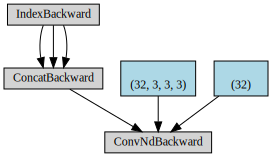

In [83]:
visualize.make_dot(out)

In [114]:
out.backward(Variable(torch.ones(1,32,320,270).double()))


In [115]:
lab_var.grad

Variable containing:
( 0 , 0 ,.,.) = 
 -7.2904e-01  3.8111e+00  2.3171e+00  ...   1.0961e+37  3.9877e+00  3.1044e+00
  1.3782e+34  1.7563e+34  2.9693e+00  ...  -4.0641e+37  2.9769e+00  2.2427e+00
  4.2816e+33 -3.9366e+33  4.0037e+00  ...  -1.4791e+03  4.0205e+00  3.0211e+00
                 ...                   ⋱                   ...                
  7.0979e+35  2.6572e+36  3.1901e+00  ...   4.9298e+21  2.9248e+00  2.4395e+00
  3.7625e+33 -2.6702e+34  4.0543e+00  ...  -2.5401e+15  4.1752e+00  2.3064e+00
  5.5592e+33 -5.8936e+34  1.5239e+00  ...  -4.8376e+14  1.8362e+00  7.8697e+00

( 0 , 1 ,.,.) = 
  0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
                 ...                   ⋱                   ...                
  0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e

In [ ]:
!ls /home/wxian3/training_handbags_pretrain/train_seg/wendy | less -10

100000_AB.jpg
100001_AB.jpg
100002_AB.jpg
100003_AB.jpg
100004_AB.jpg
100005_AB.jpg
100006_AB.jpg
100007_AB.jpg
100008_AB.jpg
100009_AB.jpg
10000_AB.jpg
100010_AB.jpg
100011_AB.jpg
100012_AB.jpg
100013_AB.jpg
100014_AB.jpg
100015_AB.jpg
100016_AB.jpg
100017_AB.jpg
100018_AB.jpg
100019_AB.jpg
10001_AB.jpg
100020_AB.jpg
:

In [1]:
from dataloader import imfol

In [2]:
A=imfol.make_dataset('/home/wxian3/training_handbags_pretrain/')

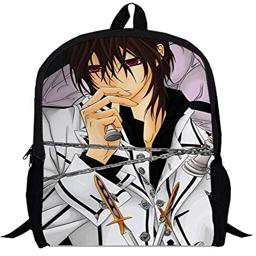

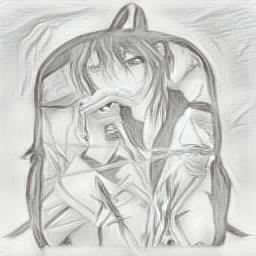

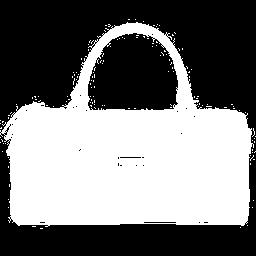

In [10]:
from PIL import Image
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

@interact(x=100)
def disp_set(x):
    display(Image.open(A[x][0]))
    display(Image.open(A[x][1]))
    display(Image.open(A[x][2]))

In [4]:
ImageFolder()

('/home/wxian3/training_handbags_pretrain/train_img/wendy/100002_AB.jpg',
 '/home/wxian3/training_handbags_pretrain/train_skg/wendy/100002_AB.jpg',
 '/home/wxian3/training_handbags_pretrain/train_seg/wendy/100002_AB.jpg')

In [11]:
!ls /home/wxian3/training_handbags_pretrain/

texture        train_seg     train_txt	       val_img	val_skg_bu
train_img      train_skg     train_txt_backup  val_seg	val_txt
train_img.zip  train_skg_bu  val	       val_skg	val_txt_backup
